In [79]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import itertools
import operator
from skimage.feature import graycoprops
from skimage.feature import graycomatrix
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import aaa
import pickle
import math
from skimage import io, color
import numpy as np
from tqdm import trange
from extraction import *
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import binary_dilation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def map_is_valid_coords_to_target(input_is_valid,
                                  input_origin_mm,
                                  input_voxel_size_mm,
                                  target_shape,
                                  target_origin_mm,
                                  target_voxel_size_mm,
                                  ):

    # voxels in feature space where the features are computed
    valid_voxels = np.argwhere(input_is_valid).T
    valid_voxel_pos = (valid_voxels * input_voxel_size_mm + np.array(input_origin_mm).reshape(3, 1))

    # indices of valid voxels in target space
    valid_target_ind = valid_voxel_pos - np.array(target_origin_mm).reshape(3, 1)
    valid_target_ind = valid_target_ind / target_voxel_size_mm

    # clip values out of range and convert to indexable dtype
    min_index = np.zeros((3, 1))
    max_index = np.array(target_shape).reshape(3, 1) - 1
    valid_target_ind = np.clip(valid_target_ind, min_index, max_index)
    valid_target_ind = np.rint(valid_target_ind).astype('int32')

    return valid_target_ind




### Load patient 

In [52]:
#DATA_PATH = "/Users/sunyiyou/cudi_research"
DATA_PATH = "/Volumes/NIH-AA/florian/graph_intermediate"
patient_id = "TULIP/AVL-061"

#bmode = aaa.load(os.path.join(DATA_PATH,patient_id,"bmode_texture_cropped_0.aaa"))
#ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_lowres_0_75_0.aaa"))
ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_texture_frames_cropped_0.aaa"))

print(ceus_4d.keys())
print(ceus_4d['data4d'].shape)


dict_keys(['voxel_size_mm', 'origin_mm', 'timestamps_s', 'dynamic_range_db', 'max_radius_mm', 'data4d', 'is_valid', 'type', 'scan_settings'])
(287, 224, 234, 20)


In [53]:
registration_path = "/Volumes/NIH-AA/florian/local-data/annotations_g3g4lt20"

registration_file = open(os.path.join(registration_path,patient_id,"annotations.pkl"), "rb")

registration = pickle.load(registration_file)

print(registration.keys())
print(registration['annotations'])
print(registration['histology_map'].shape)
valid_target_ind = map_is_valid_coords_to_target(
                                  
                                  ceus_4d['is_valid'],
                                  ceus_4d['origin_mm'],
                                  ceus_4d['voxel_size_mm'],
                                  registration['is_valid'].shape,
                                  registration['origin_mm'],
                                  registration['voxel_size_mm'],
                                  )


dict_keys(['origin_mm', 'voxel_size_mm', 'annotations', 'histology_map', 'is_valid'])
['binary_sparse', 'binary', 'dense']
(95, 75, 78, 3)


In [54]:
## recover the high-resolution map

frame_idx = 13
valid_source_ind = np.argwhere(ceus_4d['is_valid']).T
print(valid_source_ind.shape)
sample_size = 20
target = np.full(ceus_4d['is_valid'].shape, np.nan, dtype='float32')
target_mask = np.zeros(ceus_4d['is_valid'].shape,)
#annotation = registration['histology_map'][:,:,:,2]
annotation = crop_image_mask(registration['histology_map'][:,:,:,2],registration['is_valid'])
#print(high_res[valid_source_ind[0,0:sample_size],valid_source_ind[1,0:sample_size],valid_source_ind[2,0:sample_size]].shape)
for i in range(0, valid_source_ind.shape[1], sample_size):
    target[tuple(valid_source_ind[:, i:i + sample_size].reshape(3, -1, 1))] = annotation[tuple(valid_target_ind[:, i:i + sample_size].reshape(3, -1, 1))]
    target_mask[tuple(valid_source_ind[:, i:i + sample_size].reshape(3, -1, 1))] = registration['is_valid'][tuple(valid_target_ind[:, i:i + sample_size].reshape(3, -1, 1))]

(3, 10283071)


In [55]:
slice_idx = 75
valid_annotation = np.argwhere(target_mask[slice_idx,:,:])
benign_annotation = valid_annotation[target[slice_idx,:,:][tuple(valid_annotation.T)] < .5]
malignant_annotation = valid_annotation[target[slice_idx,:,:][tuple(valid_annotation.T)] > .5]
print(benign_annotation.shape, malignant_annotation.shape)


(4500, 2) (1161, 2)


### SLIC 2D

In [85]:
class Cluster(object):
    cluster_index = 1

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []
        self.boundarypixels = []
        self.no = self.cluster_index
        Cluster.cluster_index += 1

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

    def __str__(self):
        return "{},{}:{} {} {} ".format(self.h, self.w, self.l, self.a, self.b)

    def __repr__(self):
        return self.__str__()


class SLICProcessor(object):
    @staticmethod
    

    @staticmethod
    def save_lab_image(path, lab_arr):
        """
        Convert the array to RBG, then save the image
        :param path:
        :param lab_arr:
        :return:
        """
        abs_path = os.path.join("outputs",path)
        gray_arr = lab_arr[:,:,0]
        
        io.imsave(abs_path, gray_arr)

    def make_cluster(self, h, w):
        h = int(h)
        w = int(w)
        return Cluster(h, w,
                       self.data[h][w][0],
                       self.data[h][w][1],
                       self.data[h][w][2])
    
    def __init__(self, image, K, M):
        self.K = K # total number of superpixels 
        self.M = M

        self.data = image
        self.image_height = self.data.shape[0]
        self.image_width = self.data.shape[1]
        self.N = self.image_height * self.image_width
        self.S = int(math.sqrt(self.N / self.K))

        self.clusters = []
        self.label = {}
        self.dis = np.full((self.image_height, self.image_width), np.inf)

    def init_clusters(self):
        h = self.S / 2
        w = self.S / 2
        while h < self.image_height:
            while w < self.image_width:
                self.clusters.append(self.make_cluster(h, w))
                w += self.S
            w = self.S / 2
            h += self.S

    def get_gradient(self, h, w):
        if w + 1 >= self.image_width:
            w = self.image_width - 2
        if h + 1 >= self.image_height:
            h = self.image_height - 2
        
        gradient = self.data[h + 1][w + 1][0] - self.data[h][w][0] + self.data[h + 1][w + 1][1] - self.data[h][w][1] + self.data[h + 1][w + 1][2] - self.data[h][w][2]
        
        return gradient

    def move_clusters(self):
        for cluster in self.clusters:
            cluster_gradient = self.get_gradient(cluster.h, cluster.w)
            for dh in range(-1, 2):
                for dw in range(-1, 2):
                    _h = cluster.h + dh
                    _w = cluster.w + dw
                    new_gradient = self.get_gradient(_h, _w)
                    if new_gradient < cluster_gradient:
                        cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])
                        cluster_gradient = new_gradient

    def assignment(self):
        for cluster in self.clusters:
            for h in range(cluster.h - 2 * self.S, cluster.h + 2 * self.S):
                if h < 0 or h >= self.image_height: continue
                for w in range(cluster.w - 2 * self.S, cluster.w + 2 * self.S):
                    if w < 0 or w >= self.image_width: continue
                    L, A, B = self.data[h][w]
                    Dc = math.sqrt(
                        math.pow(L - cluster.l, 2) +
                        math.pow(A - cluster.a, 2) +
                        math.pow(B - cluster.b, 2))
                    Ds = math.sqrt(
                        math.pow(h - cluster.h, 2) +
                        math.pow(w - cluster.w, 2))
                    D = math.sqrt(math.pow(Dc / self.M, 2) + math.pow(Ds / self.S, 2))
                    if D < self.dis[h][w]:
                        if (h, w) not in self.label:
                            self.label[(h, w)] = cluster
                            cluster.pixels.append((h, w))
                        else:
                            self.label[(h, w)].pixels.remove((h, w))
                            self.label[(h, w)] = cluster
                            cluster.pixels.append((h, w))
                        self.dis[h][w] = D

    def update_cluster(self):
        for cluster in self.clusters:
            sum_h = sum_w = number = 0
            for p in cluster.pixels:
                sum_h += p[0]
                sum_w += p[1]
                number += 1
            _h = int(sum_h / number)
            _w = int(sum_w / number)
            cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])

    def save_current_image(self, name, boundaryflag=False):
        image_arr = np.copy(self.data)
        for cluster in self.clusters:
            for p in cluster.pixels:
                image_arr[p[0]][p[1]][0] = cluster.l
                image_arr[p[0]][p[1]][1] = cluster.a
                image_arr[p[0]][p[1]][2] = cluster.b
            image_arr[cluster.h][cluster.w][0] = 0
            image_arr[cluster.h][cluster.w][1] = 0
            image_arr[cluster.h][cluster.w][2] = 0
        #print(self.clusters[0].pixels)
        self.superdata = image_arr
        
        self.save_lab_image(name, image_arr)

    def iterate_times(self, iter):
        self.init_clusters()
        self.move_clusters()
        for i in trange(iter):
            self.assignment()
            self.update_cluster()
            if i % 9 ==0:
                name = 'ceus2d{m}_K{k}_loop{loop}.png'.format(loop=i, m=self.M, k=self.K)
                self.save_current_image(name)
            


In [86]:
image = np.repeat(ceus_4d['data4d'][:, :, :, frame_idx,np.newaxis], 3, axis=3).squeeze()
p = SLICProcessor(image[75,:,:], 300, 40)
p.iterate_times(1)

/var/folders/84/xt8pzl1j3yg89z8_j1mxygpw0000gn/T/ipykernel_7022/3846957076.py:79: RuntimeWarning: overflow encountered in ubyte_scalars
  gradient = self.data[h + 1][w + 1][0] - self.data[h][w][0] + self.data[h + 1][w + 1][1] - self.data[h][w][1] + self.data[h + 1][w + 1][2] - self.data[h][w][2]
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/84/xt8pzl1j3yg89z8_j1mxygpw0000gn/T/ipykernel_7022/3846957076.py:103: RuntimeWarning: overflow encountered in ubyte_scalars
  math.pow(L - cluster.l, 2) +
/var/folders/84/xt8pzl1j3yg89z8_j1mxygpw0000gn/T/ipykernel_7022/3846957076.py:104: RuntimeWarning: overflow encountered in ubyte_scalars
  math.pow(A - cluster.a, 2) +
/var/folders/84/xt8pzl1j3yg89z8_j1mxygpw0000gn/T/ipykernel_7022/3846957076.py:105: RuntimeWarning: overflow encountered in ubyte_scalars
  math.pow(B - cluster.b, 2))
100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


In [78]:
print(p.data.shape)
print(len(p.clusters))## how many superpixel created
print(len(p.clusters[0].pixels)) ## pixels numbers of one superpixel
print(p.clusters[0].pixels[100]) ## returns to pixel indexes

(224, 234, 3)
306
169
(7, 9)


### one bad way to find boundaries

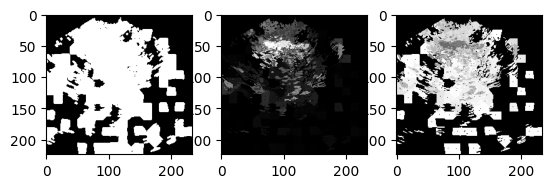

In [88]:
diation = binary_dilation(p.superdata[:,:,0])
plt.figure
plt.subplot(1,3,1)
plt.imshow(diation,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(p.superdata[:,:,0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(diation-p.superdata[:,:,0],cmap='gray')



### SLIC 3D

(160, 81, 144, 3)


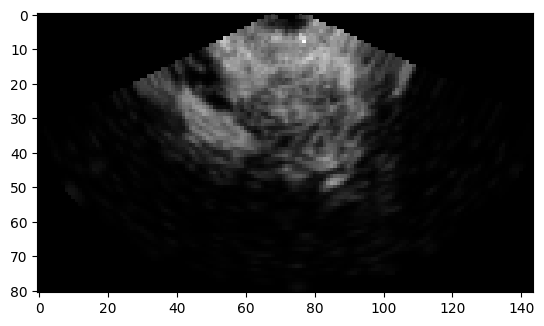

In [45]:
#image = np.repeat(bmode['data4d'][:, :, :, np.newaxis], 3, axis=3).squeeze()
image = np.repeat(ceus_4d['data4d'][:, :, :, 100,np.newaxis], 3, axis=3).squeeze()
print(image.shape)
plt.figure()
plt.imshow(image[60,:,:,0],cmap='gray')


In [46]:
#### 3-D gray
import math
from skimage import io, color
import numpy as np
from tqdm import trange


class Cluster(object):
    cluster_index = 1

    def __init__(self, h, w, d, l=0):
        self.update(h, w, d, l)
        self.pixels = []
        self.no = self.cluster_index
        Cluster.cluster_index += 1

    def update(self, h, w, d, l):
        self.h = h
        self.w = w
        self.d = d
        self.l = l
    

    def __str__(self):
        return "{},{}:{} {} {} ".format(self.h, self.w, self.d, self.l)

    def __repr__(self):
        return self.__str__()


class SLICProcessor(object):
    
    

    @staticmethod
    def save_lab_image(path, lab_arr,slice):
        """
        save the gray image
        :param path:
        :param lab_arr:
        :return:
        """
        abs_path = os.path.join("outputs",path)
        gray_arr = lab_arr[slice,:,:]
        
        io.imsave(abs_path, gray_arr)

    def make_cluster(self, h, w, d):
        h = int(h)
        w = int(w)
        d = int(d)
        return Cluster(h, w, d, self.data[h][w][d])
                       

    def __init__(self, image, K, M):
        self.K = K # total number of superpixels 
        self.M = M

        self.data = image
        self.image_height = self.data.shape[0]
        self.image_width = self.data.shape[1]
        self.image_depth = self.data.shape[2]
        self.N = self.image_height * self.image_width * self.image_depth
        #self.S = int(math.sqrt(self.N / self.K))
        self.S = int(math.pow(self.N/self.K, 1/3))

        self.clusters = []
        self.label = {}
        self.dis = np.full((self.image_height, self.image_width, self.image_depth), np.inf)

    def init_clusters(self):
        h = self.S / 2
        w = self.S / 2
        d = self.S / 2
        while h < self.image_height:
            while w < self.image_width:
                while d < self.image_depth:
                    self.clusters.append(self.make_cluster(h, w, d))
                    d += self.S
                d = self.S /2
                self.clusters.append(self.make_cluster(h, w, d))
                w += self.S
            w = self.S / 2
            h += self.S

    def get_gradient(self, h, w, d):
        if w + 1 >= self.image_width:
            w = self.image_width - 2
        if h + 1 >= self.image_height:
            h = self.image_height - 2
        if d + 1 >= self.image_width:
            d = self.image_depth - 2
        
        gradient = float(self.data[h + 1][w + 1][d + 1]) - float(self.data[h][w][d] )
        return gradient


    def move_clusters(self):
        for cluster in self.clusters:
            cluster_gradient = self.get_gradient(cluster.h, cluster.w, cluster.d)
            for dh in range(-1, 2):
                for dw in range(-1, 2):
                    for dd in range(-1, 2):
                        _h = cluster.h + dh
                        _w = cluster.w + dw
                        _d = cluster.d + dd
                        new_gradient = self.get_gradient(_h, _w, _d)
                        if new_gradient < cluster_gradient:
                            cluster.update(_h, _w, _d, self.data[_h][_w][_d])
                            cluster_gradient = new_gradient

    def assignment(self):
        for cluster in self.clusters:
            for h in range(cluster.h - 2 * self.S, cluster.h + 2 * self.S):
                if h < 0 or h >= self.image_height: continue
                for w in range(cluster.w - 2 * self.S, cluster.w + 2 * self.S):
                    if w < 0 or w >= self.image_width: continue
                    for d in range(cluster.d - 2 * self.S, cluster.d + 2 * self.S):
                        if d < 0 or d >= self.image_depth: continue
                        
                        L = self.data[h][w][d]
                        Dc = abs(float(L) - float(cluster.l))
                        Ds = math.sqrt(
                            math.pow(h - cluster.h, 2) +
                            math.pow(w - cluster.w, 2) +
                            math.pow(d - cluster.d, 2))
                        
                        D = math.sqrt(math.pow(Dc / self.M, 2) + math.pow(Ds / self.S, 2))
                        if D < self.dis[h][w][d]:
                            if (h, w, d) not in self.label:
                                self.label[(h, w, d)] = cluster
                                cluster.pixels.append((h, w, d))
                            else:

                                self.label[(h, w, d)].pixels.remove((h, w, d))
                                self.label[(h, w, d)] = cluster
                                cluster.pixels.append((h, w, d))
                            self.dis[h][w][d] = D

    def update_cluster(self):
        # update new origin
        for cluster in self.clusters:
            pixels = np.array(cluster.pixels)
            if pixels.shape[0] !=0:
                _hf, _wf, _df = np.mean(pixels, axis=0)
                _h, _w, _d = int(_hf), int(_wf), int(_df)
                cluster.update(_h, _w, _d, self.data[_h][_w][_d])

    def save_current_image(self, name,slice):
        image_arr = np.copy(self.data)
        for cluster in self.clusters:
            for p in cluster.pixels:
                image_arr[p[0]][p[1]][p[2]] = cluster.l # use intensity of origin to represent whole window
                
            image_arr[cluster.h][cluster.w][cluster.d] = 0 # mark the origin as dark point
            
        #print(self.clusters[0].pixels)
        
        self.save_lab_image(name, image_arr, slice)

    def iterate_times(self, iter):
        self.init_clusters()
        print("init",self.clusters[0].pixels)
        self.move_clusters()
        print("move",self.clusters[0].pixels)
        slice = 60
        for i in trange(iter):
            self.assignment()
            self.update_cluster()
            name = 'ceus3d_M{m}_K{k}_loop{loop}.png'.format(loop=i, m=self.M, k=self.K)
            self.save_current_image(name,slice)

p = SLICProcessor(image[:,:,:,0], 3000, 40)
p.iterate_times(20)

#name = 'lenna_M{m}_K{k}_loop{loop}_slice{slice}.png'.format(loop=0, m=40, k=2000, slice =slice)
#p.save_current_image(name, slice)

init []
move []


  5%|▌         | 1/20 [17:10<5:26:15, 1030.28s/it]


OSError: [Errno 28] No space left on device